In [108]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
from itertools import groupby
import glob
from scipy.signal import medfilt
from fastdtw import fastdtw

In [109]:
#!pip3 install fastdtw

In [110]:
def newfolder(pathin):
    folder = os.path.exists(pathin)
    if not folder:
        os.makedirs(pathin)

In [111]:
pathsave='/Volumes/jiarui/hanako/test_plot_counter'
if os.path.exists(pathsave)==False:
    newfolder(pathsave)

In [112]:
pathaudio_td = r"/Volumes/jiarui/hanako/audiomcut/td"
folders_td= sorted(os.listdir(pathaudio_td))

pathaudio_asd = r"/Volumes/jiarui/hanako/audiomcut/asd"
folders_asd= sorted(os.listdir(pathaudio_asd))

In [113]:
print(folders_td[0])
print(folders_asd[0])

Addalyn
Alexander


In [114]:
def remove_(pathin):
    for file in glob.glob(os.path.join(pathin, "._*")):
       try:
           os.remove(file)
           print(f"Deleted: {file}")
       except Exception as e:
           print(f"Error deleting {file}: {e}")

In [115]:
pathaudio_td_all = r"/Volumes/jiarui/hanako/audiom/TD"
pathaudio_asd_all = r"/Volumes/jiarui/hanako/audiom/ASD"
remove_(pathaudio_td_all)
remove_(pathaudio_asd_all)

In [116]:
def data_prepare(pathallin,pathin, folderin, idin):
    audio_name=pathallin+'/'+folderin[idin]+'.wav'
    audio,sr=librosa.load(audio_name,sr=None)
    path_to_p= pathin+'/'+folderin[idin]+'/'+'PAR'
    remove_(path_to_p)
    files_p= sorted(os.listdir(path_to_p))
    path_to_c = pathin+'/'+folderin[idin]+'/'+'CHI'
    remove_(path_to_c)
    files_c= sorted(os.listdir(path_to_c))
    return audio,sr,path_to_p,path_to_c,files_p,files_c

In [117]:
audio_td,sr_td,path_to_p_td,path_to_c_td,files_p_td,files_c_td= data_prepare(pathaudio_td_all,pathaudio_td, folders_td, 0)
audio_asd,sr_asd,path_to_p_asd,path_to_c_asd,files_p_asd,files_c_asd= data_prepare(pathaudio_asd_all,pathaudio_asd, folders_asd, 0)

In [118]:
def f0fitinter(path,files,fminin,fmaxin,label): #pitch counter and energy counter extraction
    t1=[]
    for i in range(len(files)):
        x,sr1=librosa.load(path+"/"+files[i],sr=None)
        f0, voiced_flag, voiced_probs = librosa.pyin(x,sr=sr1,frame_length=512, fill_na=np.nan, n_thresholds=50, fmin=fminin, fmax=fmaxin)
        #print(files[i])
        if (len(np.where(f0>10)[0]))<1:
            print(files[i])
            continue
        # Extract RMS Energy
        energy = librosa.feature.rms(y=x, frame_length=512, hop_length=128)[0]

        times = librosa.times_like(f0,sr=sr1,hop_length=128)
        duration=librosa.get_duration(y=x, sr=sr1)
        starttime=files[i].split('.')[0]
        label=label
        if label==0:
           f0[np.where(f0<160)[0]]=np.nan
           f0[np.where(f0>450)[0]]=np.nan
        if label==1:
           f0[np.where(f0<160)[0]]=np.nan
           f0[np.where(f0>490)[0]]=np.nan
        t=(starttime,f0,energy,label)
        t1.append(t)
        #print(smoothed_f0)
    return t1

In [119]:
pitch_p_td=f0fitinter(path_to_p_td,files_p_td,150,500,0)
pitch_c_td=f0fitinter(path_to_c_td,files_c_td,150,500,1)

pitch_p_asd=f0fitinter(path_to_p_asd,files_p_asd,150,500,0)
pitch_c_asd=f0fitinter(path_to_c_asd,files_c_asd,150,500,1)

135365.wav
220794.wav
383449.wav
195723.wav
256014.wav
271219.wav
294891.wav
227832.wav
261492.wav
364782.wav
406395.wav
407880.wav
447843.wav
520773.wav
449460.wav


In [120]:
import numpy as np

def format_and_plot_pitch_energy_series(t1, original_audio_duration, hop_time=0.008):

    # Sort the pitch segments by their onset time (convert from ms to seconds)
    t1_sorted = sorted(t1, key=lambda t: float(t[0]) / 1000.0)
    
    # Create overall time axis spanning the entire original audio duration
    overall_time = np.arange(0, original_audio_duration + hop_time, hop_time)
    overall_pitch = np.full(overall_time.shape, np.nan, dtype=float)
    overall_energy = np.full(overall_time.shape, np.nan, dtype=float)  # Initialize energy array

    # Insert each segment's pitch and energy counter into the overall series
    for start_str, ynew, energy, label in t1_sorted:
        onset_sec = float(start_str) / 1000.0  # Convert onset from milliseconds to seconds
        start_idx = int(round(onset_sec / hop_time))
        seg_length = len(ynew)
        end_idx = start_idx + seg_length
        
        # If the segment would exceed the overall time length, truncate the segment.
        if end_idx > len(overall_pitch):
            seg_length = len(overall_pitch) - start_idx
            ynew = ynew[:seg_length]
            energy = energy[:seg_length]  # Truncate energy too
            end_idx = start_idx + seg_length
        
        # Store values in the overall arrays
        overall_pitch[start_idx:end_idx] = ynew
        overall_energy[start_idx:end_idx] = energy

    return overall_time, overall_pitch, overall_energy

In [121]:
def standardize(arr, ignore_nan=True):
    if ignore_nan:
        mean_val = np.nanmean(arr)
        std_val = np.nanstd(arr)
    else:
        mean_val = np.mean(arr)
        std_val = np.std(arr)
    
    standardized_arr = (arr - mean_val) / std_val
    return standardized_arr

In [122]:
def findnan(pin, cin):
    mask_p = ~np.isnan(pin)
    non_nan_indices_p = np.where(mask_p)[0]
    mask_c = ~np.isnan(cin)
    non_nan_indices_c = np.where(mask_c)[0] 
    if non_nan_indices_p[0]<non_nan_indices_c[0]:
        f_out=non_nan_indices_p[0]
    else:
        f_out=non_nan_indices_c[0]
    if non_nan_indices_p[-1]>non_nan_indices_c[-1]:
        l_out=non_nan_indices_p[-1]
    else:
        l_out=non_nan_indices_c[-1]  
    return f_out,l_out

In [123]:
def plotpitch(audio_allin,sr_in,pitch_p_in, pitch_c_in,foldersin,idin):
    x_all=np.arange(len(audio_allin))/sr_in/60
    original_audio_duration=len(x_all)/16000
    print(original_audio_duration/60)
    overall_time_p, overall_pitch_p, overall_energy_p=format_and_plot_pitch_energy_series(pitch_p_in, original_audio_duration,
                                                                   hop_time=0.008)
    overall_time_c, overall_pitch_c, overall_energy_c=format_and_plot_pitch_energy_series(pitch_c_in, original_audio_duration,
                                                                   hop_time=0.008)
    f_out,l_out=findnan(overall_pitch_p, overall_pitch_c)
    p_time=overall_time_p[f_out:l_out]
    p_pitch=overall_pitch_p[f_out:l_out]
    c_time=overall_time_c[f_out:l_out]
    c_pitch=overall_pitch_c[f_out:l_out]
    # Plot the overall pitch series_parent
    plt.figure(figsize=(12, 3))
    plt.plot(p_time/60, p_pitch, c='blue',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(p_time/60),np.max(p_time/60))
    plt.ylim(140,600)
    plt.xlabel('Time (min)')
    plt.ylabel('Pitch')
    plt.title('Pitch Counter_parent')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'parent'+foldersin[idin],bbox_inches='tight')
    plt.show()
    # Plot the overall pitch series_child
    plt.figure(figsize=(12, 3))
    plt.plot(c_time/60, c_pitch, c='orange',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(c_time/60),np.max(c_time/60))
    plt.ylim(140,600)
    plt.xlabel('Time (min)')
    plt.ylabel('Pitch')
    plt.title('Pitch Counter_child')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'child'+foldersin[idin],bbox_inches='tight')
    plt.show()
    #plotting raw
    plt.figure(figsize=(12, 3))
    plt.plot(x_all[f_out*128:l_out*128],audio_allin[f_out*128:l_out*128])
    #plt.xlim(np.min(x_all[f_out*128:l_out*128]),np.max(x_all[f_out*128:l_out*128]))
    plt.xlabel('Time (min)')
    plt.ylabel('Amplitude')
    plt.title('Raw audio data')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'raw'+foldersin[idin],bbox_inches='tight')
    plt.show()

    f_out_e,l_out_e=findnan(overall_energy_p, overall_energy_c)
    p_time_e=overall_time_p[f_out_e:l_out_e]
    p_energy=overall_energy_p[f_out_e:l_out_e]
    c_time_e=overall_time_c[f_out_e:l_out_e]
    c_energy=overall_energy_c[f_out_e:l_out_e]
    # Plot the overall pitch series_parent
    plt.figure(figsize=(12, 3))
    plt.plot(p_time_e/60, p_energy, c='blue',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(p_time/60),np.max(p_time/60))
    plt.ylim(0,0.5)
    plt.xlabel('Time (min)')
    plt.ylabel('Energy')
    plt.title('Energy Counter_parent')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'parent_e'+foldersin[idin],bbox_inches='tight')
    plt.show()
    # Plot the overall pitch series_child
    plt.figure(figsize=(12, 3))
    plt.plot(c_time_e/60, c_energy, c='orange',marker='o', linestyle='-', markersize=3)
    #plt.xlim(np.min(c_time/60),np.max(c_time/60))
    plt.ylim(0,0.5)
    plt.xlabel('Time (min)')
    plt.ylabel('Energy')
    plt.title('Energy Counter_child')
    plt.grid(True)
    plt.savefig(pathsave+'/'+'child_e'+foldersin[idin],bbox_inches='tight')
    plt.show()
    return p_time,p_pitch,c_time,c_pitch, p_time_e,p_energy,c_time_e,c_energy

10.707495833333333


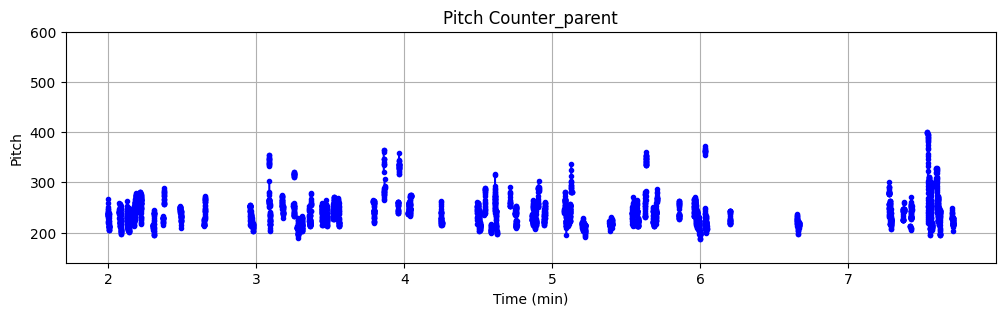

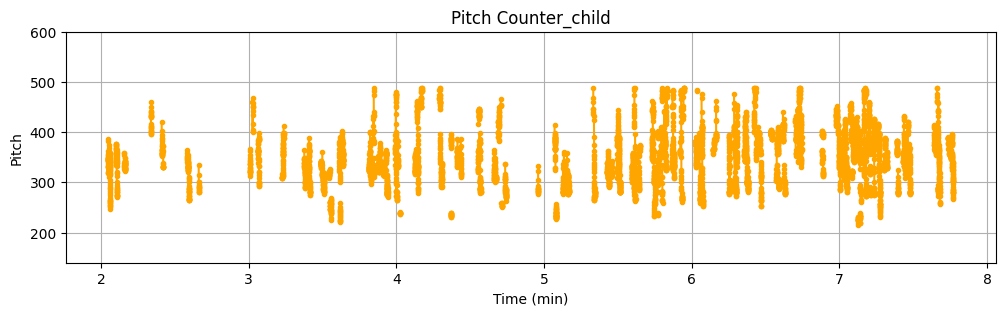

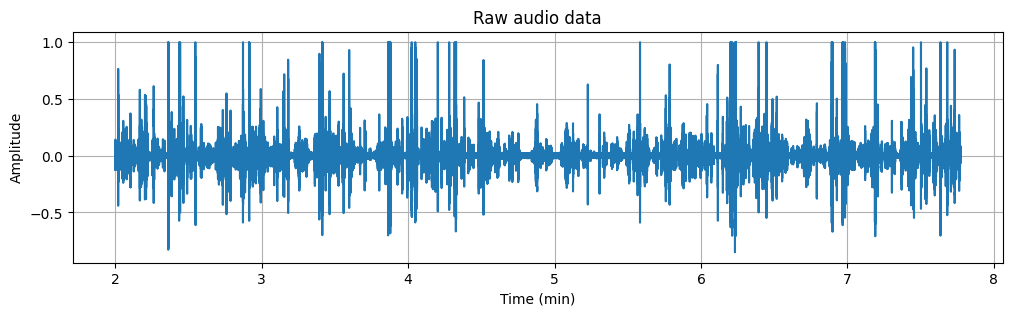

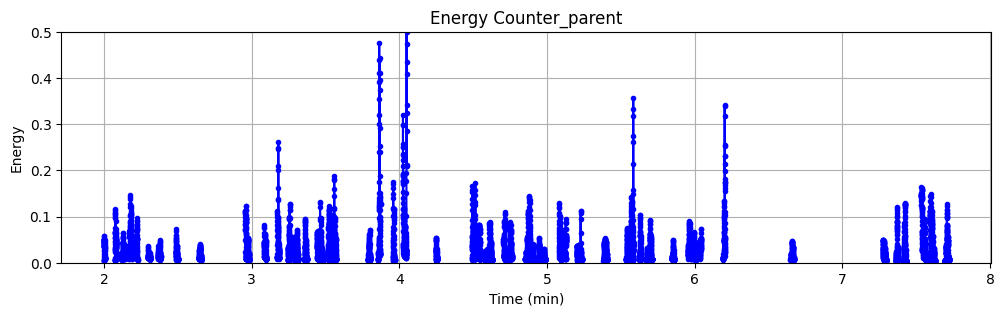

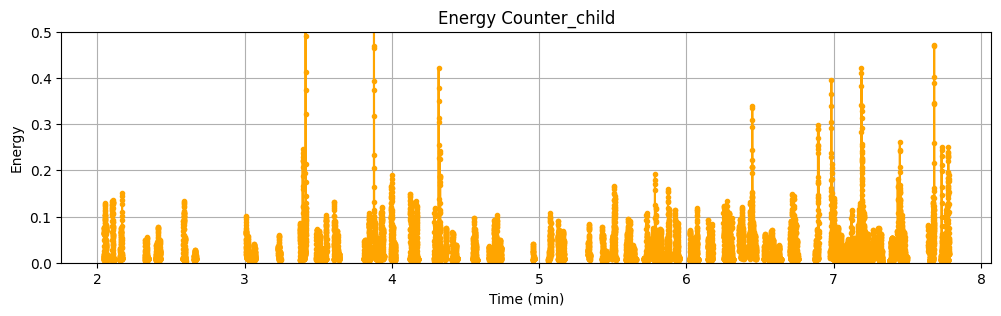

10.707495833333333


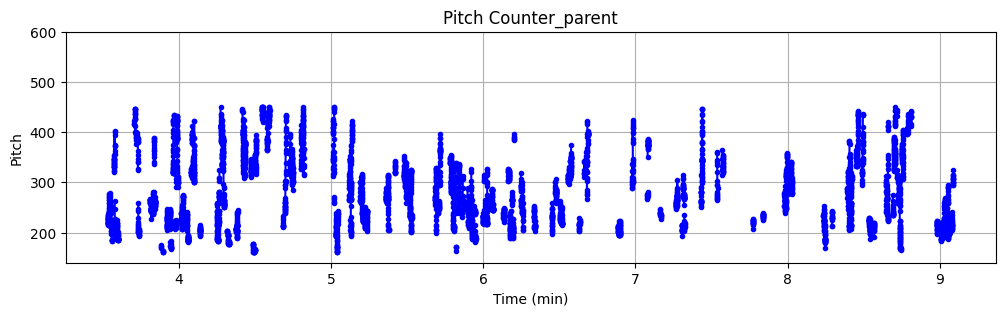

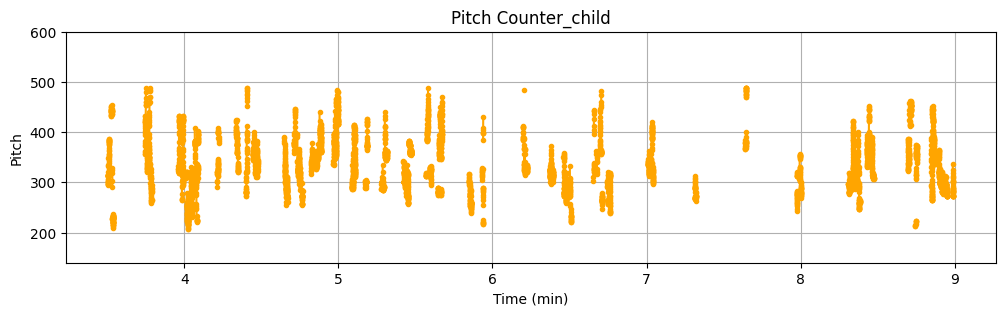

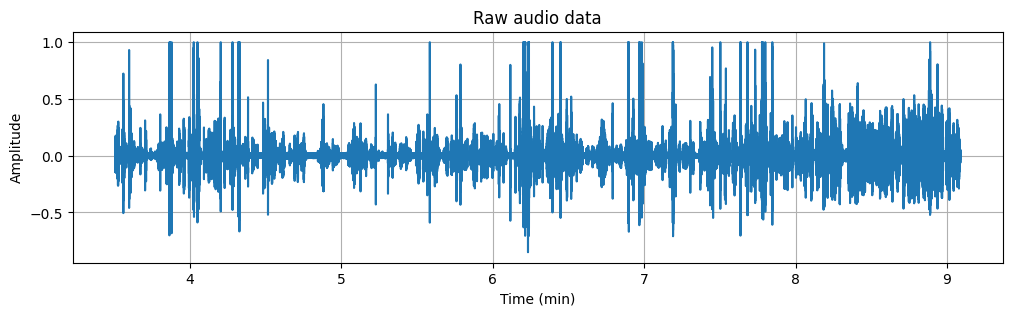

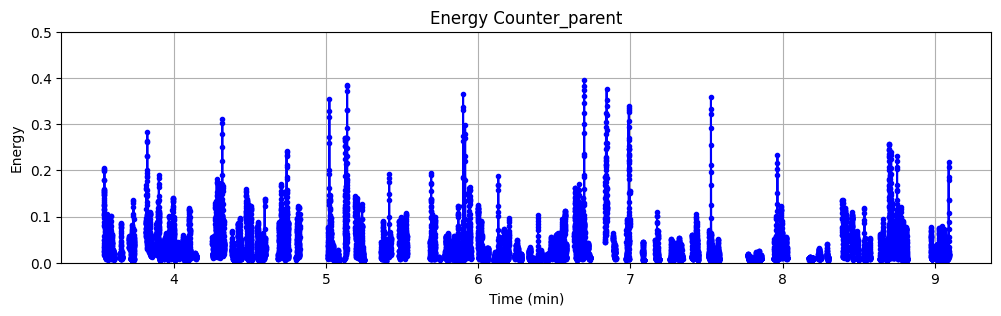

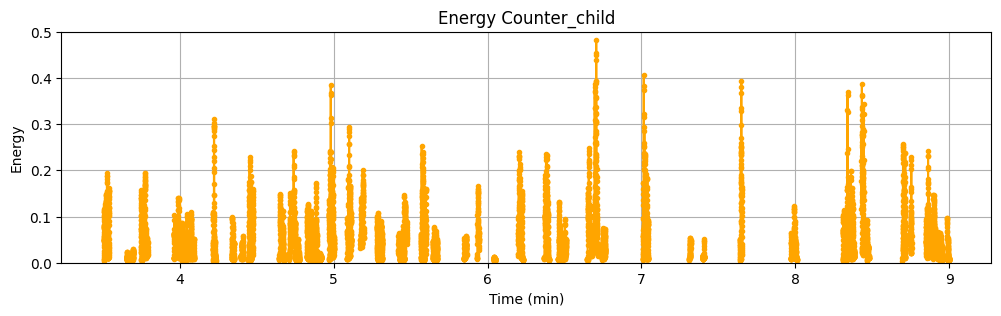

In [124]:
p_time_td,p_pitch_td,c_time_td,c_pitch_td, p_time_e_td,p_energy_td,c_time_e_td,c_energy_td=plotpitch(
    audio_td,sr_td, pitch_p_td, pitch_c_td,folders_td,0)
p_time_asd,p_pitch_asd,c_time_asd,c_pitch_asd, p_time_e_asd,p_energy_asd,c_time_e_asd,c_energy_asd=plotpitch(
    audio_td,sr_asd, pitch_p_asd, pitch_c_asd,folders_asd,0)

In [125]:
def dtw_calculate(p_pitch,c_pitch):
    p_mean = np.nanmean(p_pitch)
    c_mean = np.nanmean(c_pitch)
    # Fill NaN values with the computed mean for each series
    p_pitch_filled = np.where(np.isnan(p_pitch), p_mean, p_pitch)
    c_pitch_filled = np.where(np.isnan(c_pitch), c_mean, c_pitch)
    p_norm = standardize(p_pitch_filled)
    c_norm = standardize(c_pitch_filled)
    idnan_p=np.where(np.round(p_norm)!=0)[0]
    idnan_c=np.where(np.round(c_norm)!=0)[0]
    
    # Define a simple distance function for scalar values
    distance_func = lambda a, b: abs(a - b)
    # Compute the fastDTW distance and optimal alignment path using the normalized data
    distance, path = fastdtw(p_norm, c_norm, dist=distance_func)
    print("FastDTW distance (normalized):", distance)
    print("FastDTW distance/length:", distance/(len(idnan_p)+len(idnan_c)))
    print("FastDTW distance/p_len:", distance/len(idnan_p))
    print("FastDTW distance/c_len:", distance/len(idnan_c))
    return distance,distance/(len(idnan_p)+len(idnan_c)),distance/len(idnan_p),distance/len(idnan_c), path,p_norm,c_norm

In [126]:
p_pitch_td_clean=p_pitch_td[np.where(~np.isnan(p_pitch_td))[0]]
c_pitch_td_clean=c_pitch_td[np.where(~np.isnan(c_pitch_td))[0]]
p_pitch_asd_clean=p_pitch_asd[np.where(~np.isnan(p_pitch_asd))[0]]
c_pitch_asd_clean=c_pitch_asd[np.where(~np.isnan(c_pitch_asd))[0]]

In [127]:
p_energy_td_clean=p_energy_td[np.where(~np.isnan(p_energy_td))[0]]
c_energy_td_clean=c_energy_td[np.where(~np.isnan(c_energy_td))[0]]
p_energy_asd_clean=p_energy_asd[np.where(~np.isnan(p_energy_asd))[0]]
c_energy_asd_clean=c_energy_asd[np.where(~np.isnan(c_energy_asd))[0]]

In [128]:
distance_td,distance_td_n,distance_td_p,distance_td_c,path_td,p_norm_td,c_norm_td=dtw_calculate(p_pitch_td,c_pitch_td)
distance_asd,distance_asd_n,distance_asd_p,distance_asd_c,path_asd,p_norm_asd,c_norm_asd=dtw_calculate(p_pitch_asd,c_pitch_asd)

FastDTW distance (normalized): 17356.18301092248
FastDTW distance/length: 1.9680443373310443
FastDTW distance/p_len: 4.947600630251562
FastDTW distance/c_len: 3.2679689344610203
FastDTW distance (normalized): 14048.572548609352
FastDTW distance/length: 1.4718253062974702
FastDTW distance/p_len: 2.6980166215881223
FastDTW distance/c_len: 3.2384906751058904


In [129]:
distance_td_e,distance_td_n_e,distance_td_p_e,distance_td_c_e,path_td_e,p_norm_td_e,c_norm_td_e=dtw_calculate(p_energy_td,c_energy_td)
distance_asd_e,distance_asd_n_e,distance_asd_p_e,distance_asd_c_e,path_asd_e,p_norm_asd_e,c_norm_asd_e=dtw_calculate(p_energy_asd,c_energy_asd)

FastDTW distance (normalized): 15559.048169813579
FastDTW distance/length: 0.8552686988683805
FastDTW distance/p_len: 2.267421767679041
FastDTW distance/c_len: 1.3732610917752497
FastDTW distance (normalized): 16803.723115473495
FastDTW distance/length: 0.8728299976871751
FastDTW distance/p_len: 1.4399077219771632
FastDTW distance/c_len: 2.216265248677591


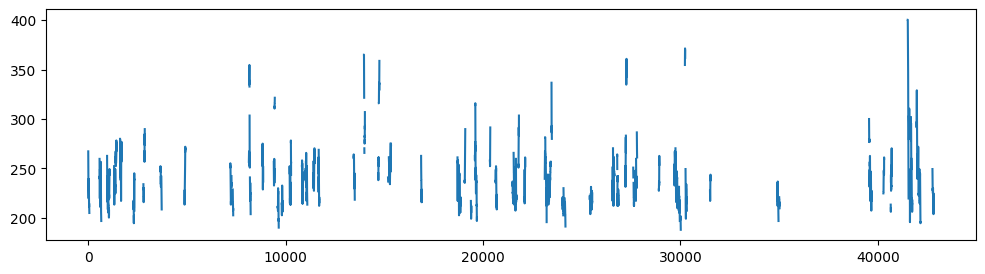

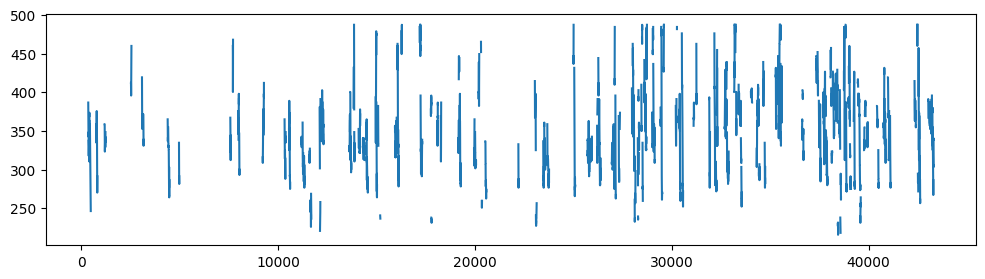

In [130]:
plt.figure(figsize=(12, 3))
plt.plot(p_pitch_td)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_pitch_td)
#plt.xlim(0,2000)

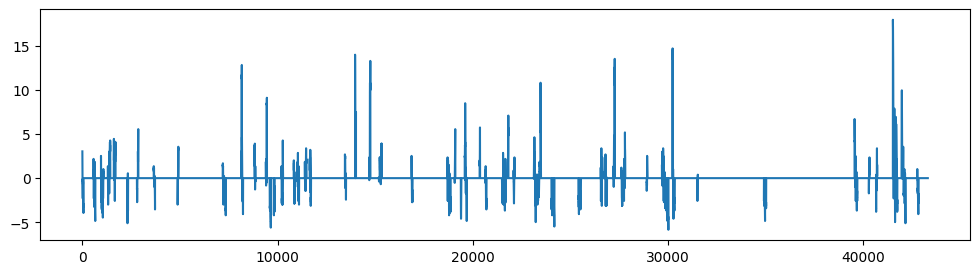

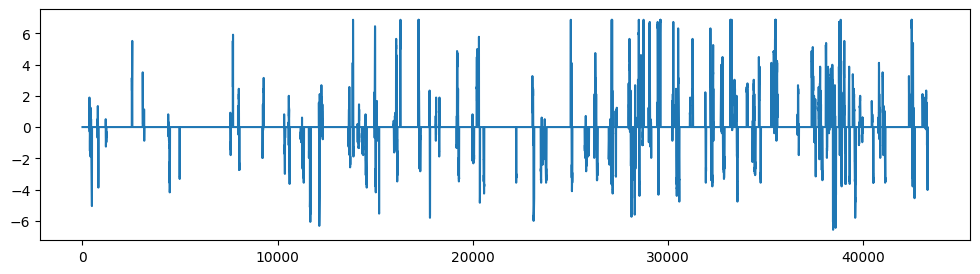

In [131]:
plt.figure(figsize=(12, 3))
plt.plot(p_norm_td)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_norm_td)
#plt.xlim(0,2000)

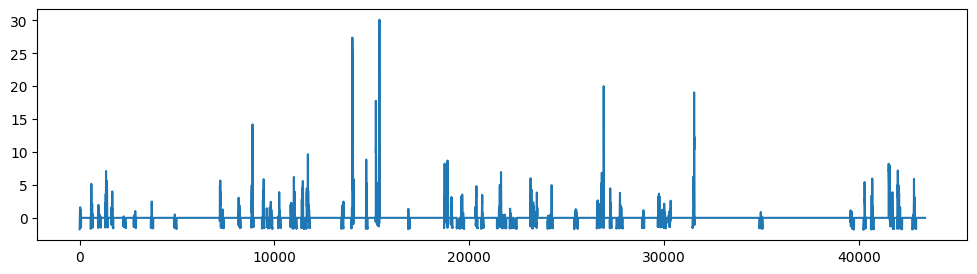

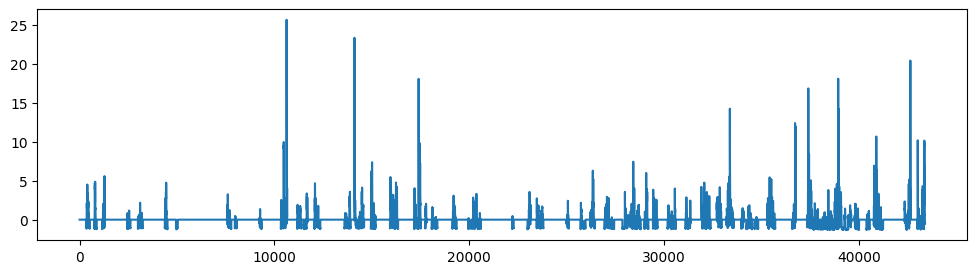

In [132]:
plt.figure(figsize=(12, 3))
plt.plot(p_norm_td_e)
#plt.xlim(0,2000)
plt.figure(figsize=(12, 3))
plt.plot(c_norm_td_e)
#plt.xlim(0,2000)

In [133]:
def path_plot(pathin,p_pitch,c_pitch,folderin,idin,namein,distancein):
    path=np.array(pathin)
    pause_mask_parent = np.isnan(p_pitch)
    #print(len(np.where(pause_mask_parent==True)[0]))
    pause_mask_child  = np.isnan(c_pitch)
    parent_pauses_on_path = pause_mask_parent[path[:, 0]]
    child_pauses_on_path  = pause_mask_child[path[:, 1]]
    #print(len(np.where(parent_pauses_on_path==True)[0]))
    pause_on_path = parent_pauses_on_path | child_pauses_on_path
    # Now plot the warping path with a diagonal line for reference.
    plt.figure(figsize=(6, 6))
    plt.plot(path[:, 0], path[:, 1],  linestyle='-', label='Alignment Path')

    # Overlay markers where pauses occurred (blue 'x' markers)
    #plt.scatter(path[pause_on_path, 0], path[pause_on_path, 1],
            #color='orange', marker='x', s=5, label='Pauses (filled)')

    # Plot the diagonal line
    max_val = max(path[:, 0].max(), path[:, 1].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Diagonal')

    plt.xlabel("Parent pitch index")
    plt.ylabel("Child pitch index")
    plt.title("FastDTW Optimal Alignment Path_"+namein+'_'+str(int(distancein)))
    plt.savefig(pathsave+'/'+'dtw'+namein+folderin[idin],bbox_inches='tight')
    plt.show()

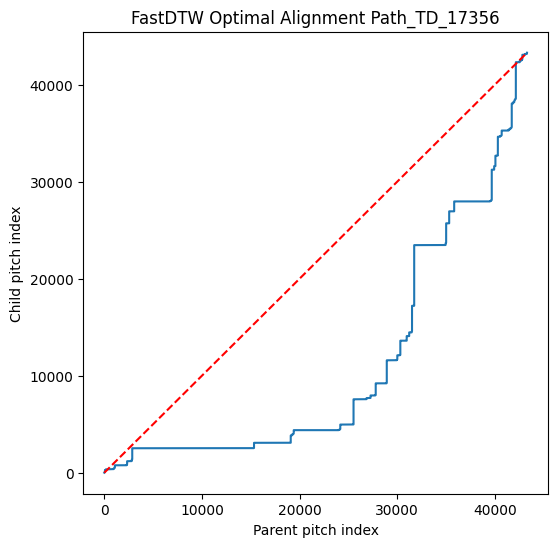

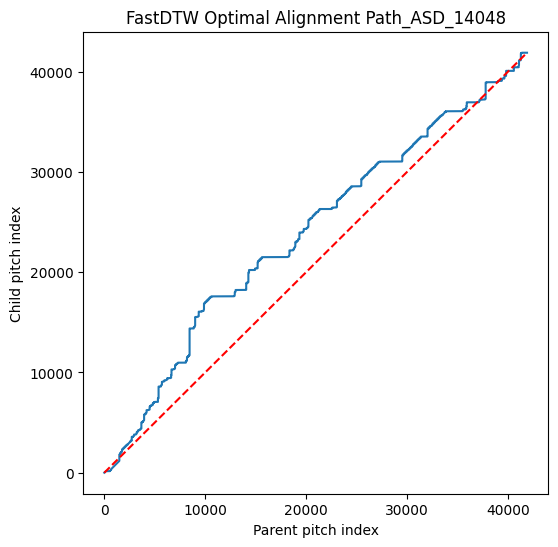

In [134]:
path_plot(path_td,p_pitch_td,c_pitch_td,folders_td,0,'TD',distance_td)
path_plot(path_asd,p_pitch_asd,c_pitch_asd,folders_asd,0,'ASD',distance_asd)

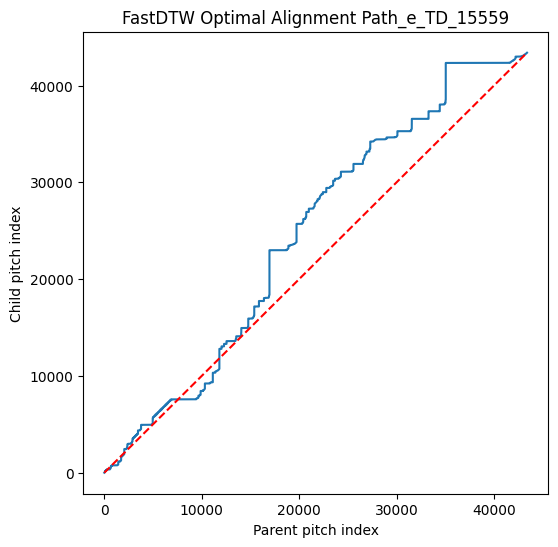

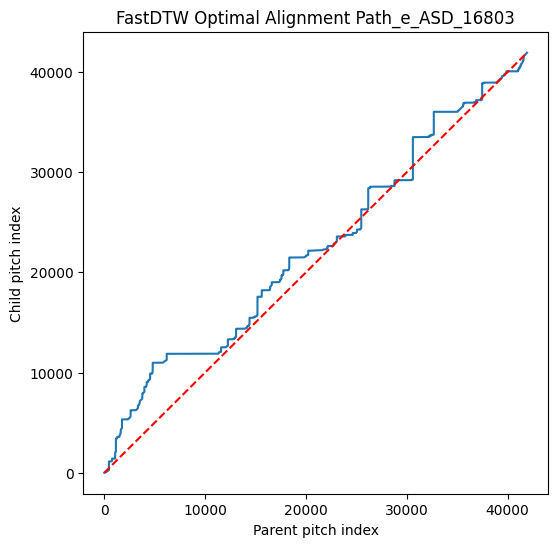

In [135]:
path_plot(path_td_e,p_energy_td,c_energy_td,folders_td,0,'e_TD',distance_td_e)
path_plot(path_asd_e,p_energy_asd,c_energy_asd,folders_asd,0,'e_ASD',distance_asd_e)

In [136]:
def plot_dtw_matching(series1, series2,pathin, offset=4):
    
    # Create x-axis indices (assumes both series have the same length)
    n1 = len(series1)
    x1 = np.arange(n1)
    n2 = len(series2)
    x2 = np.arange(n2)    
    # Prepare the plot: plot series1 (shifted upward) and series2
    plt.figure(figsize=(12, 8))
    plt.plot(x1, series1 + offset, label="Parent (shifted upward)", color="blue")
    plt.plot(x1, series2, label="Child", color="green")
    
    # For each matching pair in the warping path, draw a connecting line
    # Each pair (i, j) means that point i in series1 is matched with point j in series2.
    for i, j in pathin:
        if np.round(series1[i]) != 0 and np.round(series2[j]) != 0:
            plt.plot([i, j], [series1[i] + offset, series2[j]], color='gray', linewidth=0.5)
    #for i, j in pathin:
        #plt.plot([i, j], [series1[i] + offset, series2[j]], color='gray', linewidth=0.5)
    plt.xlim(0,20000)
    plt.xlabel("Time index")
    plt.ylabel("Standardized Pitch")
    plt.title("DTW Matching between Two Time Series")
    #plt.legend()
    #plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


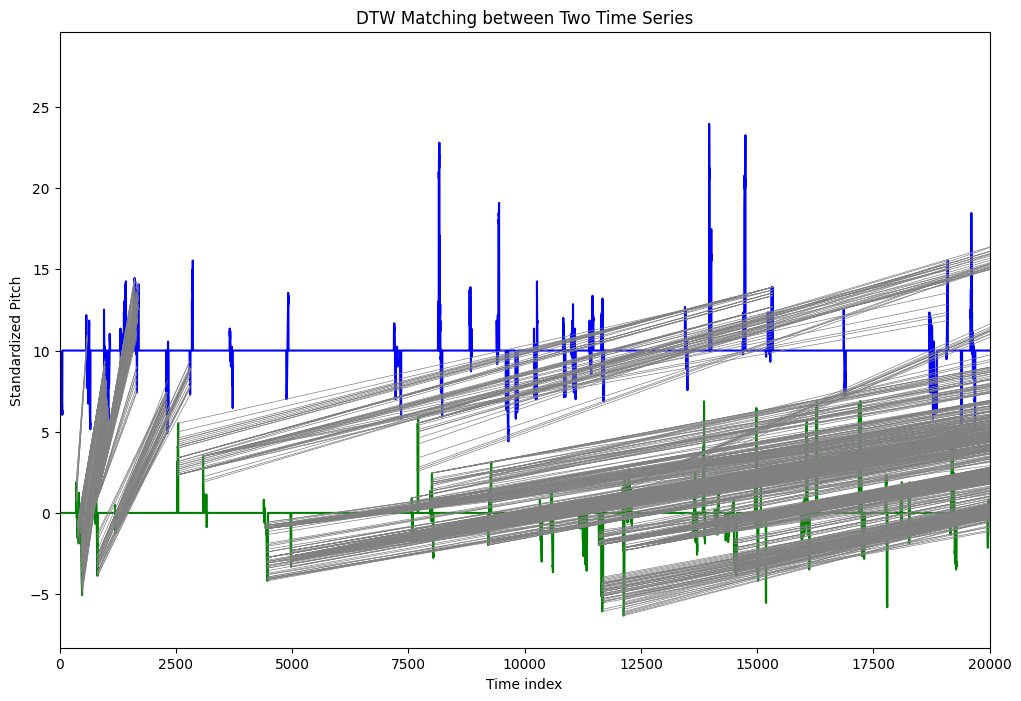

In [137]:
plot_dtw_matching(p_norm_td, c_norm_td, np.array(path_td), offset=10)

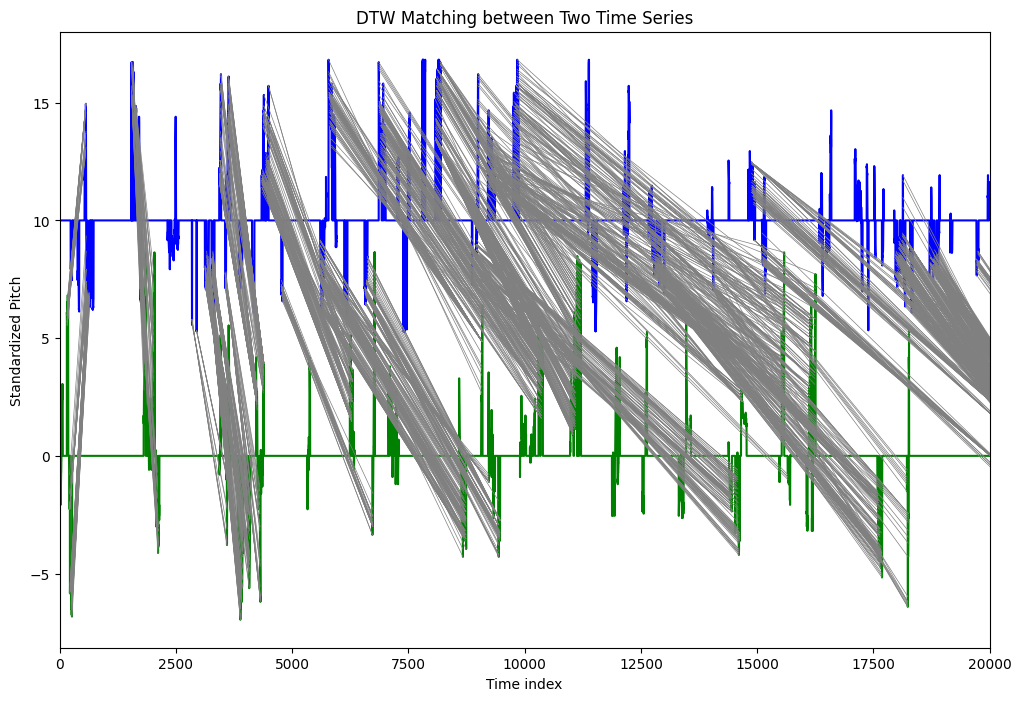

In [138]:
plot_dtw_matching(p_norm_asd, c_norm_asd, np.array(path_asd), offset=10)

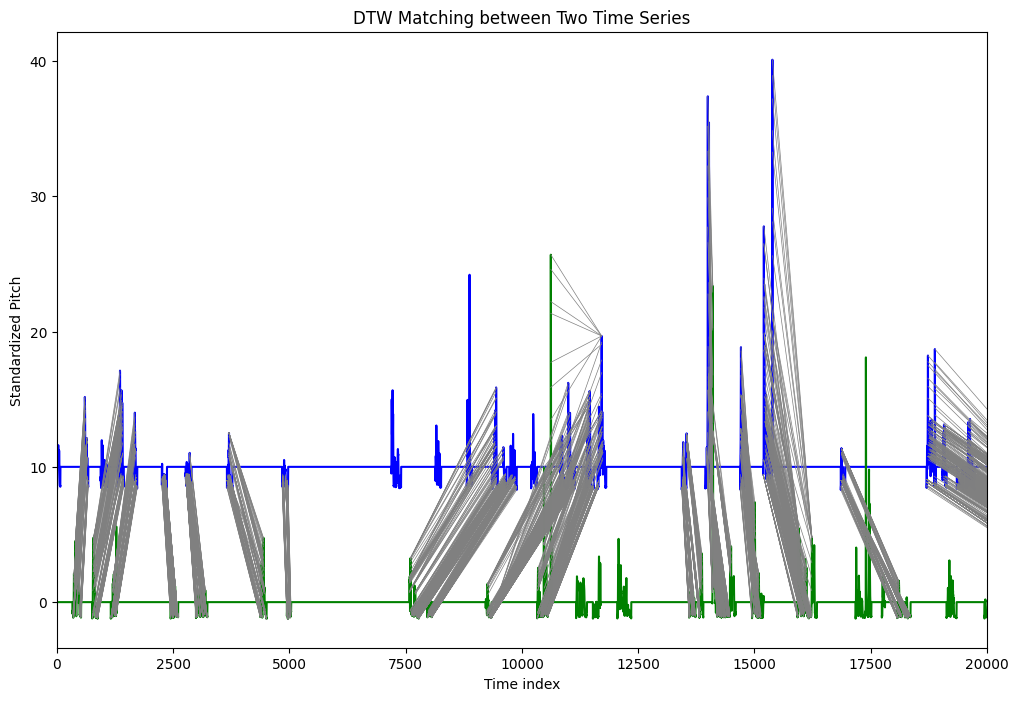

In [139]:
plot_dtw_matching(p_norm_td_e, c_norm_td_e, np.array(path_td_e), offset=10)

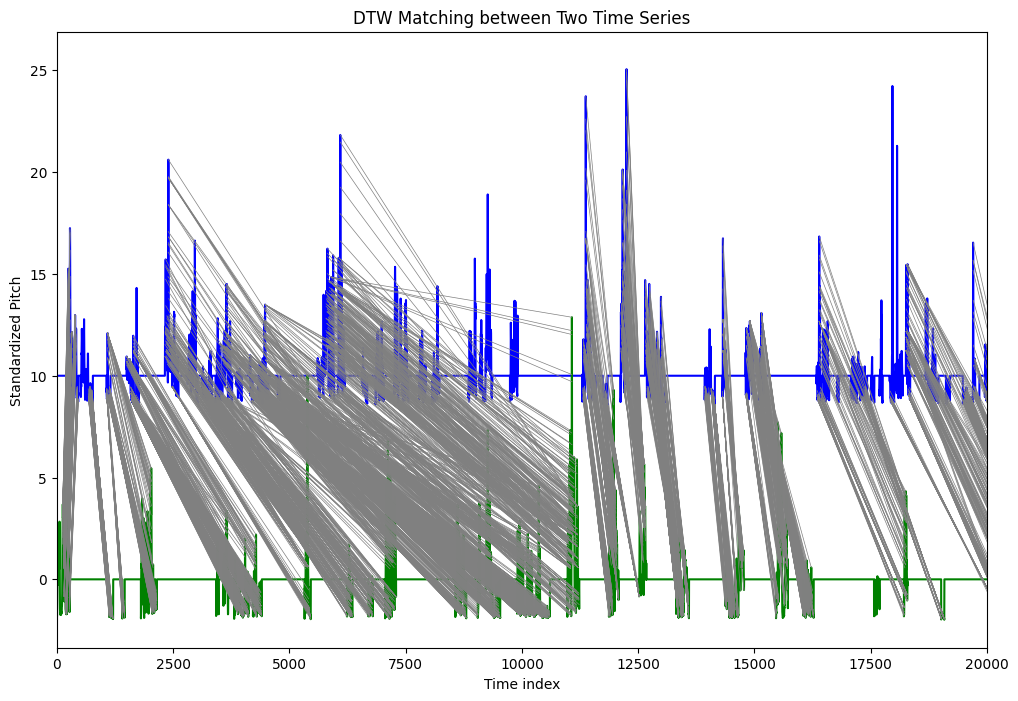

In [140]:
plot_dtw_matching(p_norm_asd_e, c_norm_asd_e, np.array(path_asd_e), offset=10)

In [141]:
def rolling_tlcc(series1, series2, window_size, max_lag):
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for i in range(len(series1) - window_size + 1):
        window1 = series1[i:i + window_size]
        window2 = series2[i:i + window_size]
        
        # Compute cross-correlation for different lags
        cross_corr = []
        for lag in lags:
            if lag > 0:
                corr = np.corrcoef(window1[:-lag], window2[lag:])[0, 1] if len(window1[:-lag]) > 1 else np.nan
            elif lag < 0:
                corr = np.corrcoef(window1[-lag:], window2[:lag])[0, 1] if len(window1[-lag:]) > 1 else np.nan
            else:
                corr = np.corrcoef(window1, window2)[0, 1]
            cross_corr.append(corr)
        
        correlations.append(cross_corr)
    
    return pd.DataFrame(correlations, columns=lags)


In [142]:
#tlcc_results = rolling_tlcc(p_norm_asd, c_norm_asd, 50, 10)

In [143]:
#plt.figure(figsize=(12, 6))
#plt.imshow(tlcc_results.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results), -10, 10],vmin=0,vmax=0.4)
#plt.xlim(0,5000)
#plt.colorbar(label="Cross-Correlation")
#plt.xlabel("Window Index")
#plt.ylabel("Lag (time steps)")
#plt.title("Rolling Window Time-Lagged Cross-Correlation")
#plt.show()

In [144]:
def normalize_with_mask(series):
    """Normalize a time series while ignoring NaN values."""
    valid_idx = ~np.isnan(series)  # Find non-NaN values
    series_norm = np.zeros_like(series) * np.nan  # Keep NaNs
    series_norm[valid_idx] = (series[valid_idx] - np.nanmin(series[valid_idx])) / (np.nanmax(series[valid_idx]) - np.nanmin(series[valid_idx]))
    return series_norm

def optimized_crp_analysis(series1, series2, threshold):
    """
    Compute Cross Recurrence Plot (CRP) efficiently using NumPy, avoiding unnecessary calculations for NaNs.
    
    :param series1: First normalized time series (NaNs preserved).
    :param series2: Second normalized time series (NaNs preserved).
    :param threshold: Distance threshold for recurrence.
    :return: CRP matrix (NxN) where N is the length of the series.
    """
    N = len(series1)
    crp_matrix = np.full((N, N), np.nan)  # Initialize with NaNs

    # Create mask of valid indices (where values are NOT NaN)
    valid_idx1 = ~np.isnan(series1)
    valid_idx2 = ~np.isnan(series2)

    # Get valid indices
    valid_rows, valid_cols = np.where(np.outer(valid_idx1, valid_idx2))

    # Compute Euclidean distances only for valid indices
    distances = np.abs(series1[valid_rows] - series2[valid_cols])  # Element-wise distance
    crp_matrix[valid_rows, valid_cols] = (distances < threshold).astype(int)  # Apply threshold

    return crp_matrix


In [145]:
# Normalize time series
series1_norm = normalize_with_mask(p_pitch_td)
series2_norm = normalize_with_mask(c_pitch_td)

# Compute CRP with a chosen threshold
threshold = 0.01  # Adjust based on data range when the threshold is 1, it shows the CRP of vocal onsets
crp_matrix = optimized_crp_analysis(series1_norm, series2_norm, threshold)



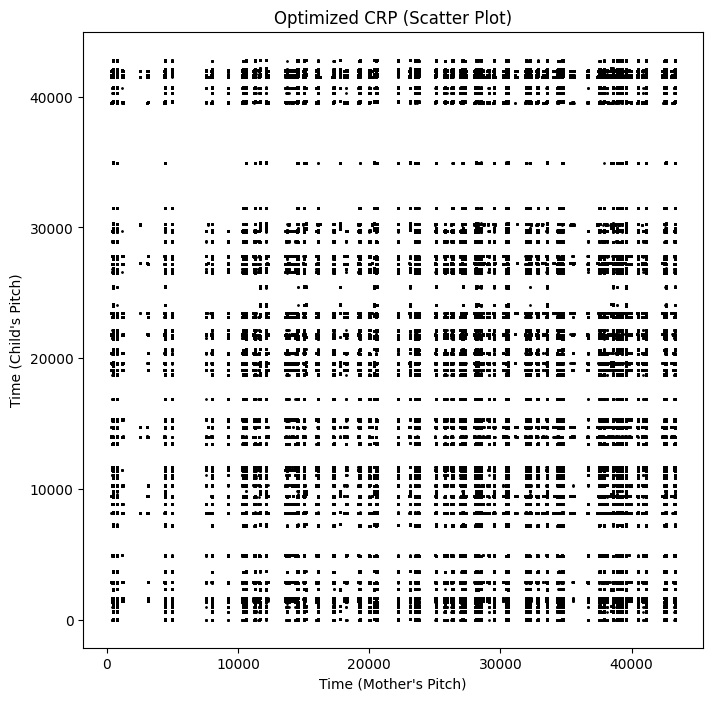

In [146]:

recurrence_points = np.argwhere(crp_matrix == 1)
plt.figure(figsize=(8, 8))
plt.scatter(recurrence_points[:, 1], recurrence_points[:, 0], s=1, color='black')
plt.xlabel("Time (Mother's Pitch)")
plt.ylabel("Time (Child's Pitch)")
plt.title("Optimized CRP (Scatter Plot)")
plt.show()

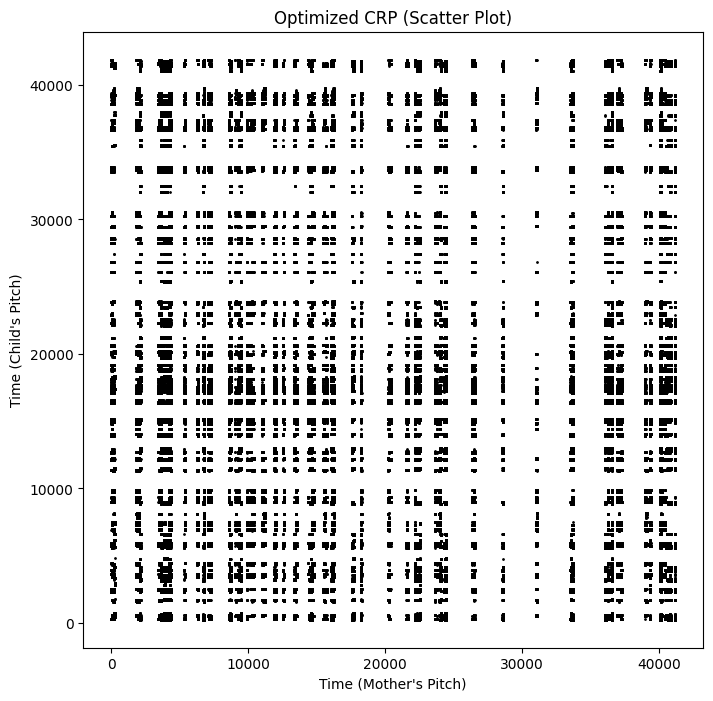

In [147]:
# Normalize time series
series1_norm = normalize_with_mask(p_pitch_asd)
series2_norm = normalize_with_mask(c_pitch_asd)

# Compute CRP with a chosen threshold
threshold = 0.01  # Adjust based on data range when the threshold is 1, it shows the CRP of vocal onsets
crp_matrix = optimized_crp_analysis(series1_norm, series2_norm, threshold)

recurrence_points = np.argwhere(crp_matrix == 1)
plt.figure(figsize=(8, 8))
plt.scatter(recurrence_points[:, 1], recurrence_points[:, 0], s=1, color='black')
plt.xlabel("Time (Mother's Pitch)")
plt.ylabel("Time (Child's Pitch)")
plt.title("Optimized CRP (Scatter Plot)")
plt.show()

In [148]:
import pycwt as wavelet  # Import the wavelet package
from pycwt.helpers import find
from scipy.ndimage import gaussian_filter

In [149]:
def smooth_wavelet_power(power, scales, sigma=1):
    """
    Custom function to smooth wavelet power using Gaussian filtering.
    
    :param power: Wavelet power spectrum (2D array).
    :param scales: Array of scales.
    :param sigma: Standard deviation for Gaussian smoothing.
    :return: Smoothed power spectrum.
    """
    smoothed = np.copy(power)
    for i in range(len(scales)):
        smoothed[i, :] = gaussian_filter(power[i, :], sigma)
    return smoothed

def cross_wavelet_analysis(series1, series2, dt=1.0):
    """
    Perform Cross-Wavelet Transform (XWT) and Wavelet Coherence (WTC).

    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param dt: Sampling period (default=1).
    :return: Wavelet coherence and cross-wavelet results.
    """
    # Remove NaNs (wavelet transform does not support NaNs)
    valid_idx = ~np.isnan(series1)| ~np.isnan(series2)
    series1,series2= series1[valid_idx],series2[valid_idx]
    series1[np.isnan(series1)]=np.nanmean(series1)
    series2[np.isnan(series2)]=np.nanmean(series2)
    series1_n=standardize(series1)
    series2_n=standardize(series2)
    
    # Define the mother wavelet (Morlet)
    mother = wavelet.Morlet(6)

    # Define the smallest scale and number of scales
    s0 = 2 * dt  # Smallest resolvable scale
    dj = 1 / 12  # Frequency scale spacing
    J = int(7 / dj)  # Number of scales

    # Compute Continuous Wavelet Transform (CWT) for both signals
    wave1, scales, freqs, coi, _, _ = wavelet.cwt(series1_n, dt, dj=dj, s0=s0, J=J, wavelet=mother)
    wave2, _, _, _, _, _ = wavelet.cwt(series2_n, dt, dj=dj, s0=s0, J=J, wavelet=mother)

    # Compute Cross-Wavelet Transform (XWT)
    xwt = wave1 * np.conj(wave2)

    # Compute Wavelet Coherence (WTC) using Gaussian Smoothing
    s_wave1 = smooth_wavelet_power(np.abs(wave1) ** 2, scales)
    s_wave2 = smooth_wavelet_power(np.abs(wave2) ** 2, scales)
    s_xwt = smooth_wavelet_power(np.abs(xwt) ** 2, scales)
    coherence = s_xwt / (s_wave1 * s_wave2)  # Normalize coherence

    return coherence, freqs, coi

In [150]:
# Compute Cross-Wavelet Transform
coherence, freqs, coi = cross_wavelet_analysis(p_pitch_td, c_pitch_td,dt=1/125)

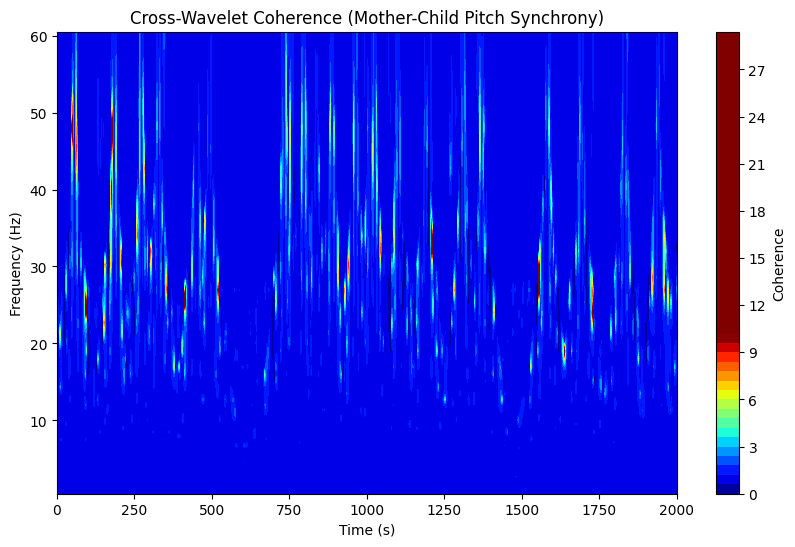

In [151]:
valid_idx = ~np.isnan(p_pitch_td)| ~np.isnan(c_pitch_td)
p_pitch_td_t= p_pitch_td[valid_idx]
time=np.arange(len(p_pitch_td_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time, freqs, coherence, cmap="jet", levels=50,vmin=0,vmax=10)
plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_td_pitch_counter_'+folders_td[0],bbox_inches='tight')
plt.show()

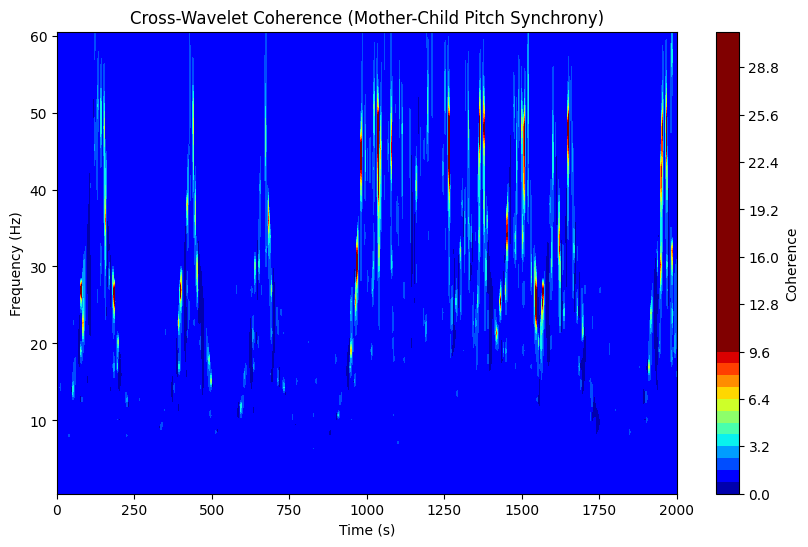

In [152]:
# Compute Cross-Wavelet Transform
coherence, freqs, coi = cross_wavelet_analysis(p_pitch_asd, c_pitch_asd,dt=1/125)
valid_idx = ~np.isnan(p_pitch_asd)| ~np.isnan(c_pitch_asd)
p_pitch_asd_t= p_pitch_asd[valid_idx]
time=np.arange(len(p_pitch_asd_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time, freqs, coherence, cmap="jet", levels=50,vmin=0,vmax=10)
plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_asd_pitch_counter_'+folders_asd[0],bbox_inches='tight')
plt.show()

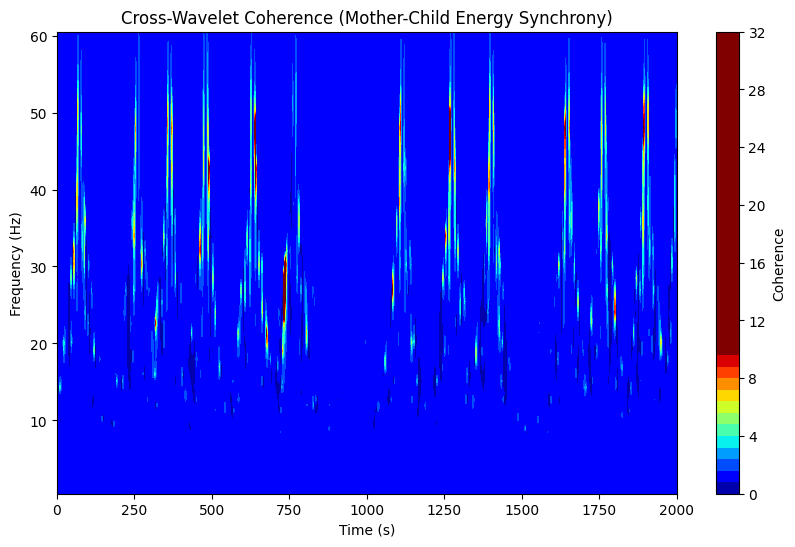

In [153]:
coherence, freqs, coi = cross_wavelet_analysis(p_energy_td, c_energy_td,dt=1/125)
valid_idx = ~np.isnan(p_energy_td)| ~np.isnan(c_energy_td)
p_energy_td_t= p_energy_td[valid_idx]
time=np.arange(len(p_energy_td_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time, freqs, coherence, cmap="jet", levels=50,vmin=0,vmax=10)
plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Energy Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_td_energy_counter_'+folders_td[0],bbox_inches='tight')
plt.show()

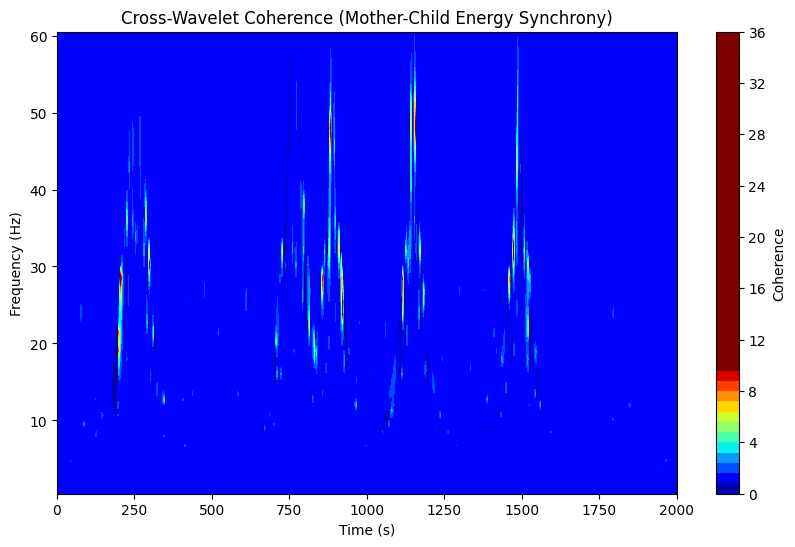

In [154]:
coherence, freqs, coi = cross_wavelet_analysis(p_energy_asd, c_energy_asd,dt=1/125)
valid_idx = ~np.isnan(p_energy_asd)| ~np.isnan(c_energy_asd)
p_energy_asd_t= p_energy_asd[valid_idx]
time=np.arange(len(p_energy_asd_t))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time, freqs, coherence, cmap="jet", levels=50,vmin=0,vmax=10)
plt.xlim(0,2000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Energy Synchrony)")

plt.colorbar(label="Coherence")
plt.savefig(pathsave+'/'+'CWT_asd_energy_counter_'+folders_asd[0],bbox_inches='tight')
plt.show()